In [1]:
from pathlib import Path
from submission import Controller
from cobar_miniproject.cobar_fly import CobarFly
from cobar_miniproject import levels
from flygym import SingleFlySimulation, Camera
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np

# Configuration
timestep = 1e-4
debug = True
level = 4
seed = 1

# Initialize fly with all required components
fly = CobarFly(
    debug=debug,
    enable_vision=True,  # Vision is required for Level 4
    render_raw_vision=True
)

# Create arena with proper parameters for Level 4
arena = levels[level](
    fly=fly, 
    timestep=timestep, 
    seed=seed
)

# Initialize camera
cam_params = {"pos": (0, 0, 80)}
cam = Camera(
    attachment_point=arena.root_element.worldbody,
    camera_name="camera_top_zoomout",
    targeted_fly_names=[fly.name],
    camera_parameters=cam_params,
    play_speed=0.2,
)

# Create simulation
sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
    timestep=timestep,
    arena=arena,
)

# Initialize controller with same timestep
controller = Controller(timestep=timestep, seed=seed)

# Simulation loop with proper error handling
obs, info = sim.reset()

# Verify observation structure - only check for essential keys
required_keys = {'odor_intensity', 'vision'}  # Removed 'heading' requirement
missing_keys = required_keys - set(obs.keys())
if missing_keys:
    raise ValueError(f"Missing required observations: {missing_keys}")

obs_hist = []
info_hist = []
max_steps = 10000

try:
    for i in trange(max_steps):
        # Render first to ensure frames are captured
        sim.render()
        
        # Get and validate observations
        obs, reward, terminated, truncated, info = sim.step(controller.get_actions(obs))
        
        # Store history and check termination
        obs_hist.append(obs.copy())
        info_hist.append(info)
        
        if controller.done_level(obs) or controller.quit or arena.quit:
            print("Simulation completed")
            break
            
except Exception as e:
    print(f"Simulation failed: {e}")
    print(f"Last observation keys: {obs.keys() if isinstance(obs, dict) else 'invalid obs'}")
finally:
    if len(obs_hist) > 0:
        save_path = Path("outputs") / f"level{level}_seed{seed}.mp4"
        save_path.parent.mkdir(parents=True, exist_ok=True)
        cam.save_video(save_path, stabilization_time=0)

# Plot results
if len(obs_hist) > 0:
    # Plot odor intensities
    odor_left = [((obs["odor_intensity"][0][0] + obs["odor_intensity"][0][2]))/2 for obs in obs_hist]
    odor_right = [((obs["odor_intensity"][0][1] + obs["odor_intensity"][0][3]))/2 for obs in obs_hist]
    
    plt.figure(figsize=(10, 5))
    plt.plot(odor_left, label="Left Odor Intensity")
    plt.plot(odor_right, label="Right Odor Intensity")
    plt.xlabel("Time Steps")
    plt.ylabel("Odor Intensity")
    plt.title("Odor Intensity Over Time")
    plt.legend()
    plt.show()

    # Print final observation data
    print("\nFinal Observation Keys:", obs.keys())
    print("\nFinal Odor Intensity:", obs["odor_intensity"])

  0%|          | 0/10000 [00:00<?, ?it/s]

Simulation failed: shape mismatch: value array of shape (46,) could not be broadcast to indexing result of shape (44,)
Last observation keys: dict_keys(['joints', 'fly', 'contact_forces', 'end_effectors', 'fly_orientation', 'cardinal_vectors', 'odor_intensity', 'vision'])


In [ ]:
# Print observation keys
print("Observation keys:", obs.keys())

# Print vision data
if "vision" in obs:
    print("Vision data:", obs["vision"])
else:
    print("Vision key is missing!")

Observation keys: dict_keys(['joints', 'end_effectors', 'contact_forces', 'heading', 'velocity', 'odor_intensity', 'vision_updated', 'reached_odour'])
Vision key is missing!


[[0.00107078 0.00105828 0.00104053 0.00103713]
 [0.         0.         0.         0.        ]]


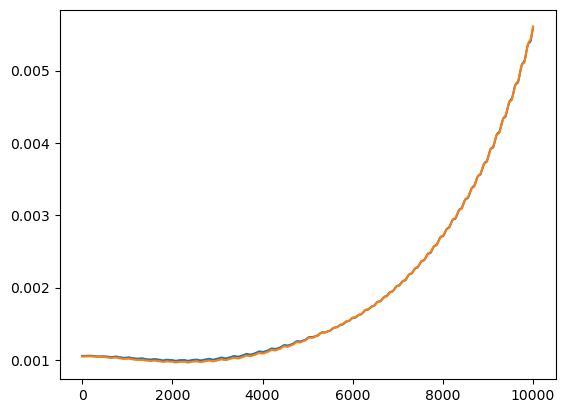

In [ ]:
#plot of the odor intensity 
import matplotlib.pyplot as plt
import numpy as np

print(obs_hist[0]["odor_intensity"])    


     
odor_left = [((obs["odor_intensity"][0][0] + obs["odor_intensity"][0][2]))/2 for obs in obs_hist]
odor_right = [((obs["odor_intensity"][0][1] + obs["odor_intensity"][0][3]))/2 for obs in obs_hist]

plt.plot(odor_left, label="Left Odor Intensity")
plt.plot(odor_right, label="Right Odor Intensity")


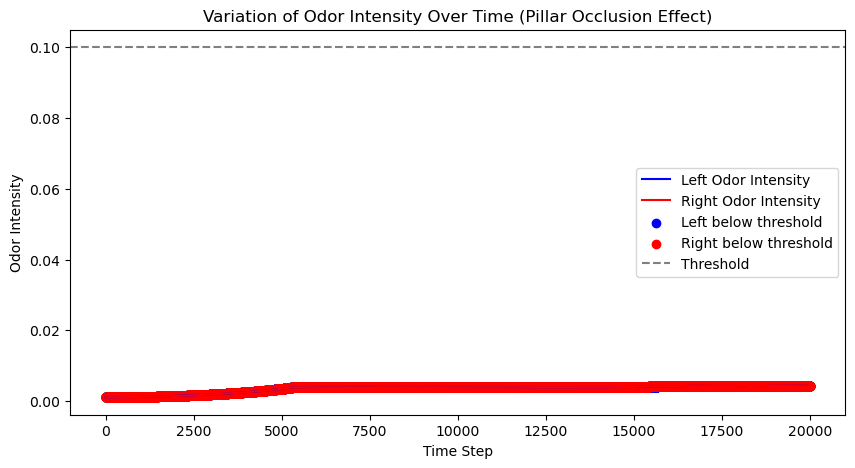

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the threshold used in the controller (assumed occlusion indicator).
ODOR_THRESHOLD = 0.1

# Compute the mean odor intensities for left and right sensors over time.
odor_left = [((obs["odor_intensity"][0][0] + obs["odor_intensity"][0][2]))/2 for obs in obs_hist]
odor_right = [((obs["odor_intensity"][0][1] + obs["odor_intensity"][0][3]))/2 for obs in obs_hist]

# Create a time vector.
time_steps = np.arange(len(obs_hist))

# Plot the odor intensity curves.
plt.figure(figsize=(10, 5))
plt.plot(time_steps, odor_left, label="Left Odor Intensity", color="blue")
plt.plot(time_steps, odor_right, label="Right Odor Intensity", color="red")

# Mark the time steps where the odor intensity drops below the threshold.
left_low = [i for i, intensity in enumerate(odor_left) if intensity < ODOR_THRESHOLD]
right_low = [i for i, intensity in enumerate(odor_right) if intensity < ODOR_THRESHOLD]
plt.scatter(left_low, [odor_left[i] for i in left_low], color="blue", marker="o", 
            label="Left below threshold")
plt.scatter(right_low, [odor_right[i] for i in right_low], color="red", marker="o", 
            label="Right below threshold")

# Plot a horizontal line at the threshold.
plt.axhline(ODOR_THRESHOLD, color='gray', linestyle='--', label="Threshold")

plt.xlabel("Time Step")
plt.ylabel("Odor Intensity")
plt.title("Variation of Odor Intensity Over Time (Pillar Occlusion Effect)")
plt.legend()
plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Define the parameters (same as used in controller.py)
# avoidance_distance = 5.0  # threshold distance for pillar effect
# aversive_gain = 80    # tuning parameter for pillar aversion

# # Compute pillar bias history
# pillar_bias_history = []
# for obs in obs_hist:
#     bias = 0.0
#     for pillar in obs.get("pillars", []):
#         pos = pillar.get("position", None)
#         if pos:
#             dist = np.hypot(pos[0], pos[1])
#             if dist < avoidance_distance:
#                 factor = 1 - (dist / avoidance_distance)
#                 # Negative bias for pillars on the left, positive for right.
#                 if pos[0] < 0:
#                     bias -= aversive_gain * factor
#                 else:
#                     bias += aversive_gain * factor
#     pillar_bias_history.append(bias)

# print(obs_hist[0].keys())
# print(obs_hist[0].get("pillars", []))

# plt.figure(figsize=(8,4))
# plt.plot(pillar_bias_history, label="Pillar Aversive Bias")
# plt.xlabel("Time step")
# plt.ylabel("Bias value")
# plt.title("Pillar Aversive Bias Over Time")
# plt.legend()
# plt.show()

I verify the keys i can use

In [ ]:
from cobar_miniproject.cobar_fly import CobarFly
from cobar_miniproject import levels
from flygym import SingleFlySimulation

# Loop through levels 0 to 5.
for lvl in range(5):
    print(f"--- Level {lvl} ---")
    # Instantiate the fly.
    fly = CobarFly(debug=False, enable_vision=False, render_raw_vision=False)
    
    # Create the arena using the corresponding level.
    if lvl <= 1:
        arena = levels[lvl](fly=fly, seed=4)
    else:
        arena = levels[lvl](fly=fly, timestep=1e-4, seed=4)
    
    # Create a simulation without cameras (for faster reset).
    sim = SingleFlySimulation(fly=fly, arena=arena, timestep=1e-4, cameras=[])  
    obs, _ = sim.reset()
    
    # Print observation dictionary keys.
    print("Observation keys:", list(obs.keys()))
    print()  # Empty line for clarity.

--- Level 0 ---
Observation keys: ['joints', 'end_effectors', 'contact_forces', 'heading', 'velocity', 'odor_intensity']

--- Level 1 ---
Observation keys: ['joints', 'end_effectors', 'contact_forces', 'heading', 'velocity', 'odor_intensity']

--- Level 2 ---
Observation keys: ['joints', 'end_effectors', 'contact_forces', 'heading', 'velocity', 'odor_intensity']

--- Level 3 ---
Observation keys: ['joints', 'end_effectors', 'contact_forces', 'heading', 'velocity', 'odor_intensity']

--- Level 4 ---
Observation keys: ['joints', 'end_effectors', 'contact_forces', 'heading', 'velocity', 'odor_intensity']

